Creating connection between Google Collab and Kaggle

In [1]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
                                  
!cp kaggle.json ~/.kaggle/      #   (!cp [   API token file name   ] ~/.kaggle/)---->  upload the kaggle API token in the directory and then write it's name in the given format.

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d teksab/imagenetvggverydeep19mat

 97% 496M/510M [00:04<00:00, 90.9MB/s]
100% 510M/510M [00:04<00:00, 123MB/s] 


In [3]:
from zipfile import ZipFile
zf = ZipFile('imagenetvggverydeep19mat.zip', 'r')
zf.extractall('/content')
zf.close()

# Libraries

In [4]:
import numpy as np 
import pandas as pd 


In [5]:

import os
import sys
import scipy.io
import imageio
import scipy.misc
from scipy import io
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint                  
%matplotlib inline

In [6]:
class CONFIG:                
    IMAGE_WIDTH = 1280
    IMAGE_HEIGHT = 720
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.5
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))


# Model Generation

In [7]:
def load_vgg_model(path):
    vgg = io.loadmat(path)
    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b
        return W, b
    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)
    def _conv2d(prev_layer, layer, layer_name):    
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filters=W, strides=[1, 1, 1, 1], padding='SAME') + b
    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))
    
    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [8]:
datapath = "imagenet-vgg-verydeep-19.mat"
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model(datapath)
pp.pprint(model)

{   'avgpool1': <tf.Tensor: shape=(1, 360, 640, 64), dtype=float32, numpy=
array([[[[0.3017254 , 0.28211457, 2.4223385 , ..., 1.0978048 ,
          0.6943143 , 1.199058  ],
         [0.42363873, 0.56422913, 2.929647  , ..., 1.4904125 ,
          0.8502542 , 1.3337204 ],
         [0.42363873, 0.56422913, 2.929647  , ..., 1.4904125 ,
          0.8502542 , 1.3337204 ],
         ...,
         [0.42363873, 0.56422913, 2.929647  , ..., 1.4904125 ,
          0.8502542 , 1.3337204 ],
         [0.42363873, 0.56422913, 2.929647  , ..., 1.4904125 ,
          0.8502542 , 1.3337204 ],
         [0.45847678, 0.75582486, 2.4548829 , ..., 1.3755593 ,
          0.82044667, 0.8522247 ]],

        [[0.5808619 , 0.56422913, 2.9793444 , ..., 1.6307089 ,
          0.75949955, 0.6912928 ],
         [0.80209965, 1.1284583 , 3.6142712 , ..., 2.1600862 ,
          0.94194293, 0.7172412 ],
         [0.80209965, 1.1284583 , 3.6142712 , ..., 2.1600862 ,
          0.94194293, 0.7172412 ],
         ...,
         [0.8

# Primary Visualizations

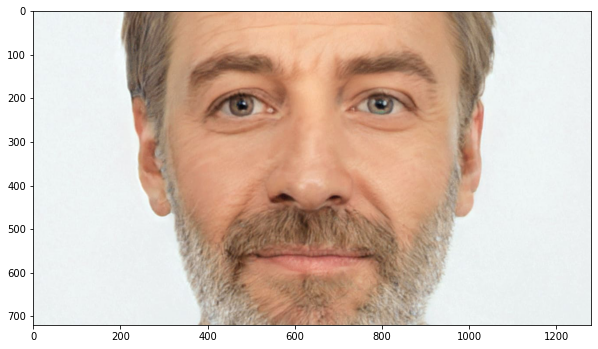

In [9]:

import imageio
content_image = imageio.imread("https://images.fastcompany.net/image/upload/w_1280,f_jpg,q_auto,fl_lossy/wp-cms/uploads/2019/09/p-1-90406423-sorry-shutterstock-these-100000-ai-generated-models-work-for-free.gif")
plt.figure(figsize=(10,10))
plt.imshow(content_image);

In [10]:
print('shape of the content image : ',content_image.shape)

shape of the content image :  (720, 1280, 3)


In [11]:
def compute_content_cost(a_C,a_G):
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    

    a_C_unrolled = tf.reshape(a_C,shape=[m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[m,-1,n_C])
    
    #Content Cost
    j_content = (1/(4*n_H*n_W*n_C))*(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))))

    return j_content

(720, 1280, 3)

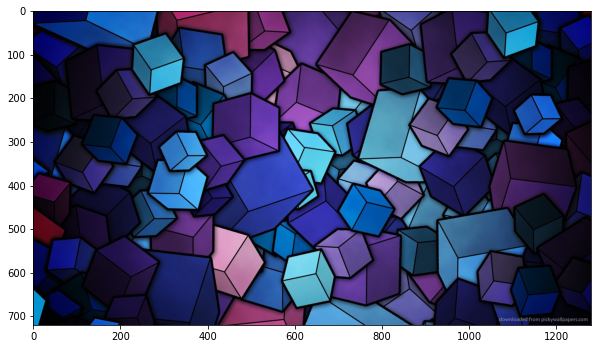

In [12]:

style_image = imageio.imread("https://wallpaperaccess.com/full/1078215.jpg")
plt.figure(figsize=(10,10))
plt.imshow(style_image)
style_image.shape

Defining all function to use in NN model

In [13]:

def compute_style_cost_layer(a_S,a_G):

    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    
    # a_S and a_G
    a_S = tf.transpose(tf.reshape(a_S,shape=[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,shape=[n_H*n_W,n_C]))
    
    # gram matrics
    S = tf.matmul(a_S,tf.transpose(a_S))
    G = tf.matmul(a_G,tf.transpose(a_G))
    
    # Style Cost
    j_style_layer = (1/(4*(n_C**2)*((n_H*n_W)**2)))*(tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(S,G)))))
    
    return j_style_layer

In [14]:
style_layers = [('conv1_2',0.3),
               ('conv3_2',0.3),
               ('conv3_3',0.3),
               ('conv4_2',0.3),
               ('conv5_1',0.3)]

In [15]:
def compute_style_cost(model, style_layers):
    

    j_style=0
    
    for layer_name,coeff in style_layers:

        out = model[layer_name]
        
        a_S = sess.run(out)
        
        a_G = model[layer_name]
        
        j_style_layer = compute_style_cost_layer(a_S,a_G)
        
        j_style += coeff*j_style_layer
        
    return j_style

In [16]:

def total_cost(j_content, j_style, alpha=10, beta=40):
    
    j = (alpha*j_content) + (beta*j_style)
    
    return j

In [17]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()

In [18]:
def reshape_and_normalize_image(image):
    image = np.reshape(image, ((1,) + image.shape))
    image = image - CONFIG.MEANS
    return image

In [19]:
content_image = imageio.imread("https://images.fastcompany.net/image/upload/w_1280,f_jpg,q_auto,fl_lossy/wp-cms/uploads/2019/09/p-1-90406423-sorry-shutterstock-these-100000-ai-generated-models-work-for-free.gif")
content_image = reshape_and_normalize_image(content_image)
style_image = imageio.imread("https://wallpaperaccess.com/full/1078215.jpg")
style_image = reshape_and_normalize_image(style_image)

In [20]:
print('shape of the style image : ',style_image.shape)

shape of the style image :  (1, 720, 1280, 3)


In [21]:
def generate_noisy_image(content_image, noise= CONFIG.NOISE_RATIO):
    
    noisy_image  = np.random.uniform(-20,20,(1,CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    input_image = (noisy_image * noise) + (content_image * (1-noise))
    
    return input_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


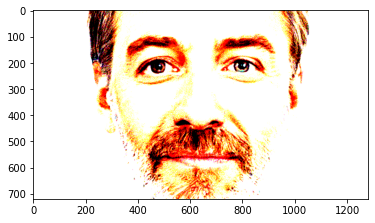

In [22]:
generated_image = generate_noisy_image(content_image)
plt.imshow(generated_image[0])
plt.show()

In [23]:
model = load_vgg_model(datapath)

In [24]:
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
j_content = compute_content_cost(a_C, a_G)

In [25]:
sess.run(model['input'].assign(style_image))
j_style = compute_style_cost(model, style_layers)

In [26]:
j = total_cost(j_content,j_style,alpha=10,beta=40)

In [27]:

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.3)
train_set = optimizer.minimize(j)

In [28]:
def save_image(path, image):  
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imsave(path, image)

# Model Fitting and Output Generation

In [29]:
def model_nn(sess, input_image, num_iterations = 150):
    sess.run(tf.compat.v1.global_variables_initializer())
    # Run the noisy input image
    generated_image = sess.run(model["input"].assign(input_image))
    for i in range(num_iterations):
        # Run the session on the train_step to minimize the total cost
        sess.run(train_set)
        generated_image = sess.run(model["input"])
        # Print every 20 iteration.
        if i%20 == 0:
            J, Jc, Js = sess.run([j, j_content, j_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(J))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            save_image("" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('generated_image.jpg', generated_image)
    
    return generated_image

In [30]:
model_nn(sess,generated_image)

Iteration 0 :
total cost = 33108226000.0
content cost = 4252.438
style cost = 827704600.0
Iteration 20 :
total cost = 28732973000.0
content cost = 6819.6577
style cost = 718322600.0
Iteration 40 :
total cost = 24120807000.0
content cost = 11115.088
style cost = 603017400.0
Iteration 60 :
total cost = 20132938000.0
content cost = 15406.374
style cost = 503319580.0
Iteration 80 :
total cost = 17230434000.0
content cost = 18372.625
style cost = 430756220.0
Iteration 100 :
total cost = 15119333000.0
content cost = 20233.336
style cost = 377978270.0
Iteration 120 :
total cost = 13473773000.0
content cost = 21508.232
style cost = 336838940.0
Iteration 140 :
total cost = 12078085000.0
content cost = 22461.686
style cost = 301946530.0


array([[[[ 31.41467  ,  31.38229  , 122.006775 ],
         [ 54.60852  ,  24.110891 , 119.12889  ],
         [ 42.508064 ,  48.65454  , 115.83354  ],
         ...,
         [ 90.29983  ,  15.820802 , 102.62522  ],
         [ 86.67894  ,   8.495901 ,  99.73803  ],
         [ 73.70703  ,   7.4196944,  72.58984  ]],

        [[ 17.729446 ,  16.57135  , 103.01008  ],
         [ 50.62419  ,  28.406267 , 120.47702  ],
         [ 31.459326 ,  39.973343 , 113.61056  ],
         ...,
         [ 98.22785  ,  24.900183 , 118.09832  ],
         [ 84.71822  ,  33.68491  , 105.94679  ],
         [ 92.99721  ,  19.38452  ,  96.78519  ]],

        [[ 23.032366 ,  16.173948 , 106.925674 ],
         [ 20.479248 ,  22.316486 , 117.21707  ],
         [ 18.85847  ,  36.45448  , 124.33041  ],
         ...,
         [ 99.8144   ,  42.39123  , 115.378136 ],
         [ 97.95195  ,  43.520294 , 113.13079  ],
         [102.09314  ,  39.37882  , 102.90494  ]],

        ...,

        [[ 28.189148 ,  23.585522 ,  6

Name of the image : 0.png


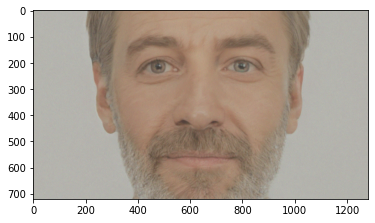





Name of the image : 20.png


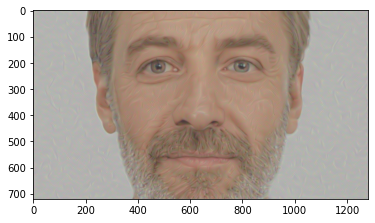





Name of the image : 40.png


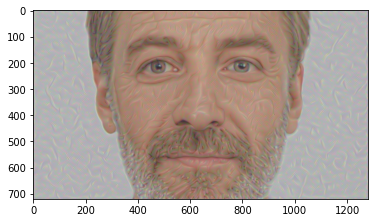





Name of the image : 60.png


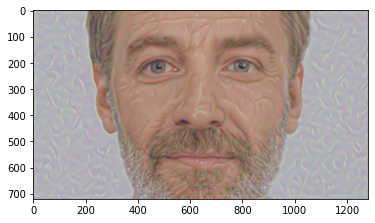





Name of the image : 80.png


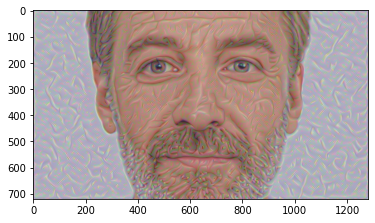





Name of the image : 100.png


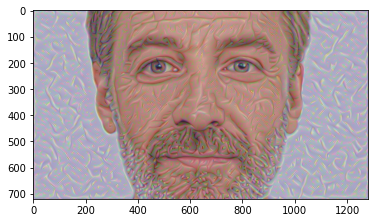





Name of the image : 120.png


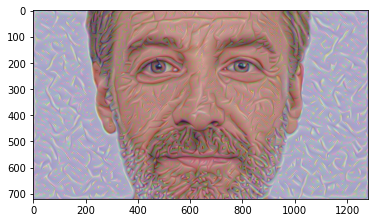





Name of the image : 140.png


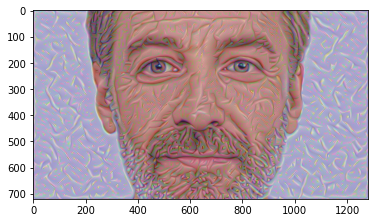

In [31]:
import matplotlib.image as mpimg

for i in range(8):
  link=str(i*20)+'.png'
  img=mpimg.imread(link)
  print('Name of the image : '+str(i*20)+'.png')
  plt.imshow(img)
  plt.show()
  print('\n\n\n')

# THE END
---

 If you find this repo helpful do **STAR** this.


 ## THANK YOU :)